from google.colab import drive
drive.mount('/content/drive')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi


Tue Jul 29 14:08:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
import os

correct_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
print(os.listdir(correct_path))

['train', 'val', 'test']


In [3]:
print("Train folders:", os.listdir(correct_path + '/train'))
print("Val folders:", os.listdir(correct_path + '/val'))
print("Test folders:", os.listdir(correct_path + '/test'))

Train folders: ['PNEUMONIA', 'NORMAL']
Val folders: ['PNEUMONIA', 'NORMAL']
Test folders: ['PNEUMONIA', 'NORMAL']


In [4]:
import os

base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

splits = ['train', 'val', 'test']
classes = ['PNEUMONIA', 'NORMAL']

for split in splits:
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{split.capitalize()} - {cls}: {count} images")


Train - PNEUMONIA: 3818 images
Train - NORMAL: 1403 images
Val - PNEUMONIA: 1135 images
Val - NORMAL: 418 images
Test - PNEUMONIA: 1141 images
Test - NORMAL: 415 images


In [6]:
# ✅ FastViT-SA12 Training with Validation Loss Logging
import os, json, torch
import numpy as np
from tqdm import tqdm
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import CosineAnnealingLR
from collections import Counter

# ---------------- FastViT-SA12 Architecture ---------------- #
class FastViTBlock(nn.Module):
    def __init__(self, in_chs, out_chs, stride=1, expansion=2):
        super().__init__()
        hidden_dim = in_chs * expansion
        self.conv = nn.Sequential(
            nn.Conv2d(in_chs, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, out_chs, 1, bias=False),
            nn.BatchNorm2d(out_chs),
        )
        self.use_residual = stride == 1 and in_chs == out_chs

    def forward(self, x):
        out = self.conv(x)
        return x + out if self.use_residual else out

class FastViTSA12(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.SiLU()
        )
        self.stage1 = FastViTBlock(16, 32, stride=1)
        self.stage2 = FastViTBlock(32, 64, stride=2)
        self.stage3 = FastViTBlock(64, 128, stride=2)
        self.stage4 = FastViTBlock(128, 128, stride=1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.global_pool(x)
        return self.classifier(x)

# ---------------- Config ---------------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
history_path = '/content/drive/MyDrive/FastViT-SA12_history.json'
model_path = '/content/drive/MyDrive/FastViT-SA12_final.pth'

image_size = 256
batch_size = 32
total_epochs = 20
lr = 1e-3
weight_decay = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# ---------------- Transforms ---------------- #
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# ---------------- Dataset ---------------- #
train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(base_path, 'val'), transform=val_transform)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
class_names   = train_dataset.classes
num_classes   = len(class_names)
print("🧾 Classes:", class_names)

# ---------------- Class Weights ---------------- #
labels_list = [label for _, label in train_dataset.samples]
class_counts = Counter(labels_list)
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(num_classes)]
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

# ---------------- Model + Optimizer ---------------- #
model = FastViTSA12(num_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# ---------------- Resume Support ---------------- #
start_epoch = 0
history = {
    "train_loss": [], "val_loss": [],
    "train_accuracy": [], "val_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": []
}
if os.path.exists(model_path):
    print("🔁 Resuming from checkpoint...")
    model.load_state_dict(torch.load(model_path, map_location=device))
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
            start_epoch = len(history["train_loss"])
    print(f"🔁 Resumed from epoch {start_epoch}/{total_epochs}")

# ---------------- Evaluation ---------------- #
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec  = recall_score(all_labels, all_preds)
    f1   = f1_score(all_labels, all_preds)
    return acc, prec, rec, f1

# ---------------- Training Loop ---------------- #
for epoch in range(start_epoch, total_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)

    # Evaluate train
    train_acc = evaluate(model, train_loader)[0]

    # Evaluate val
    val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader)

    # Compute val loss
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_running_loss += loss.item()
    avg_val_loss = val_running_loss / len(val_loader)

    # Save history
    history["train_loss"].append(avg_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(val_acc)
    history["val_precision"].append(val_prec)
    history["val_recall"].append(val_rec)
    history["val_f1"].append(val_f1)

    with open(history_path, 'w') as f:
        json.dump(history, f)
    torch.save(model.state_dict(), model_path)

    print(f"\n✅ Epoch {epoch+1} Complete:")
    print(f"   🔻 Train Loss   : {avg_loss:.4f}")
    print(f"   🔻 Val Loss     : {avg_val_loss:.4f}")
    print(f"   🎯 Train Acc    : {train_acc:.4f}")
    print(f"   🎯 Val Accuracy : {val_acc:.4f}")
    print(f"   🎯 Val Precision: {val_prec:.4f}")
    print(f"   🔁 Val Recall   : {val_rec:.4f}")
    print(f"   📈 Val F1 Score : {val_f1:.4f}")

print("✅ Training complete. Model + history saved to Drive.")


✅ Using device: cuda
🧾 Classes: ['NORMAL', 'PNEUMONIA']


Epoch 1/20: 100%|██████████| 164/164 [19:47<00:00,  7.24s/it]



✅ Epoch 1 Complete:
   🔻 Train Loss   : 0.3260
   🔻 Val Loss     : 0.1953
   🎯 Train Acc    : 0.9222
   🎯 Val Accuracy : 0.9343
   🎯 Val Precision: 0.9396
   🔁 Val Recall   : 0.9727
   📈 Val F1 Score : 0.9558


Epoch 2/20: 100%|██████████| 164/164 [00:47<00:00,  3.47it/s]



✅ Epoch 2 Complete:
   🔻 Train Loss   : 0.2308
   🔻 Val Loss     : 0.4405
   🎯 Train Acc    : 0.7903
   🎯 Val Accuracy : 0.8300
   🎯 Val Precision: 0.9943
   🔁 Val Recall   : 0.7718
   📈 Val F1 Score : 0.8690


Epoch 3/20: 100%|██████████| 164/164 [00:47<00:00,  3.45it/s]



✅ Epoch 3 Complete:
   🔻 Train Loss   : 0.2014
   🔻 Val Loss     : 0.1319
   🎯 Train Acc    : 0.9420
   🎯 Val Accuracy : 0.9543
   🎯 Val Precision: 0.9810
   🔁 Val Recall   : 0.9559
   📈 Val F1 Score : 0.9683


Epoch 4/20: 100%|██████████| 164/164 [00:46<00:00,  3.50it/s]



✅ Epoch 4 Complete:
   🔻 Train Loss   : 0.1794
   🔻 Val Loss     : 0.1365
   🎯 Train Acc    : 0.9481
   🎯 Val Accuracy : 0.9453
   🎯 Val Precision: 0.9449
   🔁 Val Recall   : 0.9824
   📈 Val F1 Score : 0.9633


Epoch 5/20: 100%|██████████| 164/164 [00:46<00:00,  3.52it/s]



✅ Epoch 5 Complete:
   🔻 Train Loss   : 0.1706
   🔻 Val Loss     : 0.1209
   🎯 Train Acc    : 0.9529
   🎯 Val Accuracy : 0.9569
   🎯 Val Precision: 0.9768
   🔁 Val Recall   : 0.9639
   📈 Val F1 Score : 0.9703


Epoch 6/20: 100%|██████████| 164/164 [00:46<00:00,  3.52it/s]



✅ Epoch 6 Complete:
   🔻 Train Loss   : 0.1544
   🔻 Val Loss     : 0.1953
   🎯 Train Acc    : 0.9173
   🎯 Val Accuracy : 0.9279
   🎯 Val Precision: 0.9876
   🔁 Val Recall   : 0.9128
   📈 Val F1 Score : 0.9487


Epoch 7/20: 100%|██████████| 164/164 [00:46<00:00,  3.55it/s]



✅ Epoch 7 Complete:
   🔻 Train Loss   : 0.1573
   🔻 Val Loss     : 0.1523
   🎯 Train Acc    : 0.9376
   🎯 Val Accuracy : 0.9408
   🎯 Val Precision: 0.9869
   🔁 Val Recall   : 0.9313
   📈 Val F1 Score : 0.9583


Epoch 8/20: 100%|██████████| 164/164 [00:46<00:00,  3.54it/s]



✅ Epoch 8 Complete:
   🔻 Train Loss   : 0.1530
   🔻 Val Loss     : 0.1664
   🎯 Train Acc    : 0.9370
   🎯 Val Accuracy : 0.9408
   🎯 Val Precision: 0.9851
   🔁 Val Recall   : 0.9330
   📈 Val F1 Score : 0.9584


Epoch 9/20: 100%|██████████| 164/164 [00:46<00:00,  3.54it/s]



✅ Epoch 9 Complete:
   🔻 Train Loss   : 0.1444
   🔻 Val Loss     : 0.1252
   🎯 Train Acc    : 0.9581
   🎯 Val Accuracy : 0.9543
   🎯 Val Precision: 0.9845
   🔁 Val Recall   : 0.9524
   📈 Val F1 Score : 0.9682


Epoch 10/20: 100%|██████████| 164/164 [00:46<00:00,  3.52it/s]



✅ Epoch 10 Complete:
   🔻 Train Loss   : 0.1314
   🔻 Val Loss     : 0.1346
   🎯 Train Acc    : 0.9556
   🎯 Val Accuracy : 0.9485
   🎯 Val Precision: 0.9889
   🔁 Val Recall   : 0.9401
   📈 Val F1 Score : 0.9639


Epoch 11/20: 100%|██████████| 164/164 [00:46<00:00,  3.53it/s]



✅ Epoch 11 Complete:
   🔻 Train Loss   : 0.1418
   🔻 Val Loss     : 0.0880
   🎯 Train Acc    : 0.9692
   🎯 Val Accuracy : 0.9672
   🎯 Val Precision: 0.9746
   🔁 Val Recall   : 0.9806
   📈 Val F1 Score : 0.9776


Epoch 12/20: 100%|██████████| 164/164 [00:46<00:00,  3.52it/s]



✅ Epoch 12 Complete:
   🔻 Train Loss   : 0.1282
   🔻 Val Loss     : 0.0996
   🎯 Train Acc    : 0.9672
   🎯 Val Accuracy : 0.9627
   🎯 Val Precision: 0.9753
   🔁 Val Recall   : 0.9736
   📈 Val F1 Score : 0.9744


Epoch 13/20: 100%|██████████| 164/164 [00:46<00:00,  3.55it/s]



✅ Epoch 13 Complete:
   🔻 Train Loss   : 0.1197
   🔻 Val Loss     : 0.1250
   🎯 Train Acc    : 0.9604
   🎯 Val Accuracy : 0.9543
   🎯 Val Precision: 0.9935
   🔁 Val Recall   : 0.9436
   📈 Val F1 Score : 0.9679


Epoch 14/20: 100%|██████████| 164/164 [00:46<00:00,  3.55it/s]



✅ Epoch 14 Complete:
   🔻 Train Loss   : 0.1189
   🔻 Val Loss     : 0.1011
   🎯 Train Acc    : 0.9627
   🎯 Val Accuracy : 0.9575
   🎯 Val Precision: 0.9777
   🔁 Val Recall   : 0.9639
   📈 Val F1 Score : 0.9707


Epoch 15/20: 100%|██████████| 164/164 [00:46<00:00,  3.53it/s]



✅ Epoch 15 Complete:
   🔻 Train Loss   : 0.1163
   🔻 Val Loss     : 0.0957
   🎯 Train Acc    : 0.9651
   🎯 Val Accuracy : 0.9614
   🎯 Val Precision: 0.9855
   🔁 Val Recall   : 0.9612
   📈 Val F1 Score : 0.9732


Epoch 16/20: 100%|██████████| 164/164 [00:46<00:00,  3.51it/s]



✅ Epoch 16 Complete:
   🔻 Train Loss   : 0.1206
   🔻 Val Loss     : 0.1005
   🎯 Train Acc    : 0.9623
   🎯 Val Accuracy : 0.9620
   🎯 Val Precision: 0.9864
   🔁 Val Recall   : 0.9612
   📈 Val F1 Score : 0.9737


Epoch 17/20: 100%|██████████| 164/164 [00:46<00:00,  3.51it/s]



✅ Epoch 17 Complete:
   🔻 Train Loss   : 0.1073
   🔻 Val Loss     : 0.0941
   🎯 Train Acc    : 0.9617
   🎯 Val Accuracy : 0.9633
   🎯 Val Precision: 0.9865
   🔁 Val Recall   : 0.9630
   📈 Val F1 Score : 0.9746


Epoch 18/20: 100%|██████████| 164/164 [00:46<00:00,  3.55it/s]



✅ Epoch 18 Complete:
   🔻 Train Loss   : 0.1101
   🔻 Val Loss     : 0.1009
   🎯 Train Acc    : 0.9623
   🎯 Val Accuracy : 0.9607
   🎯 Val Precision: 0.9900
   🔁 Val Recall   : 0.9559
   📈 Val F1 Score : 0.9727


Epoch 19/20: 100%|██████████| 164/164 [00:46<00:00,  3.54it/s]



✅ Epoch 19 Complete:
   🔻 Train Loss   : 0.1092
   🔻 Val Loss     : 0.0791
   🎯 Train Acc    : 0.9697
   🎯 Val Accuracy : 0.9742
   🎯 Val Precision: 0.9824
   🔁 Val Recall   : 0.9824
   📈 Val F1 Score : 0.9824


Epoch 20/20: 100%|██████████| 164/164 [00:45<00:00,  3.58it/s]



✅ Epoch 20 Complete:
   🔻 Train Loss   : 0.1059
   🔻 Val Loss     : 0.0851
   🎯 Train Acc    : 0.9657
   🎯 Val Accuracy : 0.9646
   🎯 Val Precision: 0.9830
   🔁 Val Recall   : 0.9683
   📈 Val F1 Score : 0.9756
✅ Training complete. Model + history saved to Drive.


In [5]:
import json

# ✅ Load training history for FastViT-SA12
with open('/content/drive/MyDrive/FastViT-SA12_history.json', 'r') as f:
    history = json.load(f)

# ✅ Extract final epoch's training and validation accuracy
final_train_acc = history['train_accuracy'][-1]
final_val_acc   = history['val_accuracy'][-1]

print(f"✅ Final Training Accuracy   : {final_train_acc * 100:.2f}%")
print(f"✅ Final Validation Accuracy : {final_val_acc * 100:.2f}%")


✅ Final Training Accuracy   : 96.57%
✅ Final Validation Accuracy : 96.46%


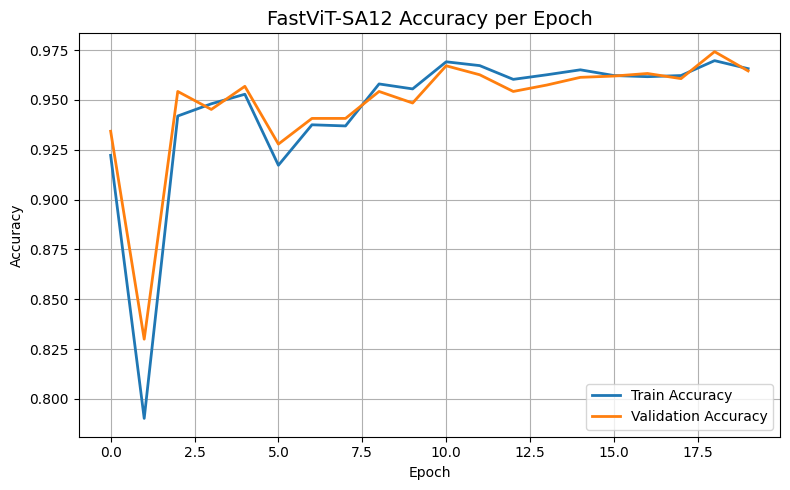

In [6]:
import matplotlib.pyplot as plt
import json

# ✅ Load training history for FastViT-SA12
with open('/content/drive/MyDrive/FastViT-SA12_history.json', 'r') as f:
    history = json.load(f)

# ✅ Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history['train_accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('FastViT-SA12 Accuracy per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


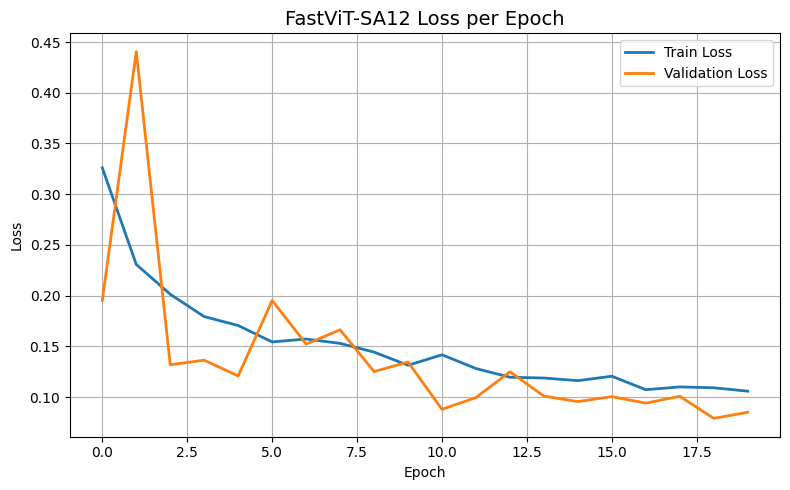

In [7]:
import matplotlib.pyplot as plt
import json

# ✅ Load training history for FastViT-SA12
with open('/content/drive/MyDrive/FastViT-SA12_history.json', 'r') as f:
    history = json.load(f)

# ✅ Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('FastViT-SA12 Loss per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# ✅ Paste your FastViTSA12 model here
class FastViTBlock(nn.Module):
    def __init__(self, in_chs, out_chs, stride=1, expansion=2):
        super().__init__()
        hidden_dim = in_chs * expansion
        self.conv = nn.Sequential(
            nn.Conv2d(in_chs, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, out_chs, 1, bias=False),
            nn.BatchNorm2d(out_chs),
        )
        self.use_residual = stride == 1 and in_chs == out_chs

    def forward(self, x):
        out = self.conv(x)
        return x + out if self.use_residual else out

class FastViTSA12(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.SiLU()
        )
        self.stage1 = FastViTBlock(16, 32, stride=1)
        self.stage2 = FastViTBlock(32, 64, stride=2)
        self.stage3 = FastViTBlock(64, 128, stride=2)
        self.stage4 = FastViTBlock(128, 128, stride=1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.global_pool(x)
        return self.classifier(x)

# -------- CONFIG -------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
model_path = '/content/drive/MyDrive/FastViT-SA12_final.pth'
batch_size = 32
image_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- DATASET PREP -------- #
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_dataset = datasets.ImageFolder(os.path.join(base_path, 'test'), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes

# -------- LOAD MODEL -------- #
model = FastViTSA12(num_classes=2).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# -------- EVALUATE -------- #
criterion = nn.CrossEntropyLoss()
all_preds, all_labels = [], []
running_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_loss = running_loss / len(test_loader)
test_accuracy = accuracy_score(all_labels, all_preds)

print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {avg_loss:.4f}")


✅ Test Accuracy: 96.14%
📉 Test Loss: 0.0949


📊 Overall Model Performance (FastViT-SA12, Threshold = 0.50):

✅ Accuracy :  0.9614
🎯 Precision: 0.9883
🔁 Recall   : 0.9588
📈 F1 Score : 0.9733


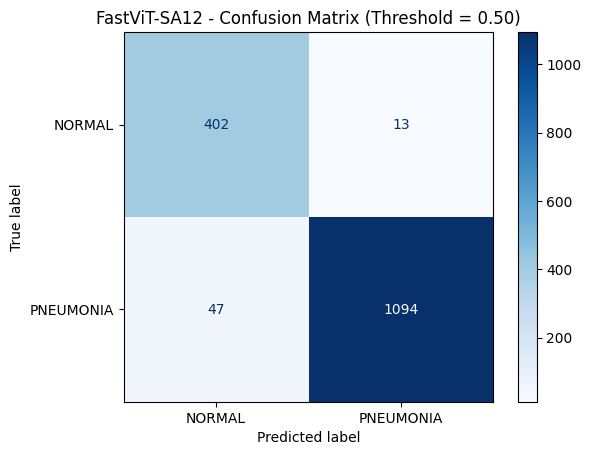


🧮 Confusion Matrix Breakdown:
✅ True Positives (TP): 1094
✅ True Negatives (TN): 402
❌ False Positives (FP): 13
❌ False Negatives (FN): 47


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

# ✅ FastViT-SA12 Model Definition
class FastViTBlock(nn.Module):
    def __init__(self, in_chs, out_chs, stride=1, expansion=2):
        super().__init__()
        hidden_dim = in_chs * expansion
        self.conv = nn.Sequential(
            nn.Conv2d(in_chs, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, out_chs, 1, bias=False),
            nn.BatchNorm2d(out_chs),
        )
        self.use_residual = stride == 1 and in_chs == out_chs

    def forward(self, x):
        out = self.conv(x)
        return x + out if self.use_residual else out

class FastViTSA12(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.SiLU()
        )
        self.stage1 = FastViTBlock(16, 32, stride=1)
        self.stage2 = FastViTBlock(32, 64, stride=2)
        self.stage3 = FastViTBlock(64, 128, stride=2)
        self.stage4 = FastViTBlock(128, 128, stride=1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.global_pool(x)
        return self.classifier(x)

# -------- CONFIG -------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
model_path = '/content/drive/MyDrive/FastViT-SA12_final.pth'
image_size = 256
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- DATASET PREP -------- #
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_dataset = datasets.ImageFolder(os.path.join(base_path, 'test'), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes

# -------- LOAD TRAINED MODEL -------- #
model = FastViTSA12(num_classes=2).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# -------- Step 1–2: Predict on Test Set -------- #
all_labels, all_probs = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1 (PNEUMONIA)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -------- Step 3: Apply Threshold -------- #
threshold = 0.50
y_true = np.array(all_labels)
y_pred = (np.array(all_probs) > threshold).astype(int)

# -------- Step 4: Metrics -------- #
overall_accuracy  = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred)
overall_recall    = recall_score(y_true, y_pred)
overall_f1        = f1_score(y_true, y_pred)

# -------- Step 5: Print Metrics -------- #
print("📊 Overall Model Performance (FastViT-SA12, Threshold = 0.50):\n")
print(f"✅ Accuracy :  {overall_accuracy:.4f}")
print(f"🎯 Precision: {overall_precision:.4f}")
print(f"🔁 Recall   : {overall_recall:.4f}")
print(f"📈 F1 Score : {overall_f1:.4f}")

# -------- Step 6: Confusion Matrix -------- #
cm = confusion_matrix(y_true, y_pred)
labels = class_names  # ['NORMAL', 'PNEUMONIA']

# -------- Step 7: Plot Confusion Matrix -------- #
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("FastViT-SA12 - Confusion Matrix (Threshold = 0.50)")
plt.grid(False)
plt.show()

# -------- Step 8: TP, TN, FP, FN Breakdown -------- #
tn, fp, fn, tp = cm.ravel()
print("\n🧮 Confusion Matrix Breakdown:")
print(f"✅ True Positives (TP): {tp}")
print(f"✅ True Negatives (TN): {tn}")
print(f"❌ False Positives (FP): {fp}")
print(f"❌ False Negatives (FN): {fn}")
